In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np
import theano

In [50]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

# Parameters
true_A = 1.
true_B = -1.
A = theano.shared(true_A, name="A")
B = theano.shared(true_B, name="B")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=B, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Define p1 at fixed arbitrary value theta1 := 0,0
p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Draw data
X_true = p0.rvs(500, random_state=777) 

In [51]:
# Projection operator
print(R)

[[ 1.31229955  0.10499961  0.48310515 -0.3249938  -0.26387927]
 [ 0.10499961  1.15833058 -0.55865473  0.25275522 -0.39790775]
 [ 0.48310515 -0.55865473  2.25874579 -0.52087938 -0.39271231]
 [-0.3249938   0.25275522 -0.52087938  1.4034925  -0.63521059]
 [-0.26387927 -0.39790775 -0.39271231 -0.63521059  1.        ]]


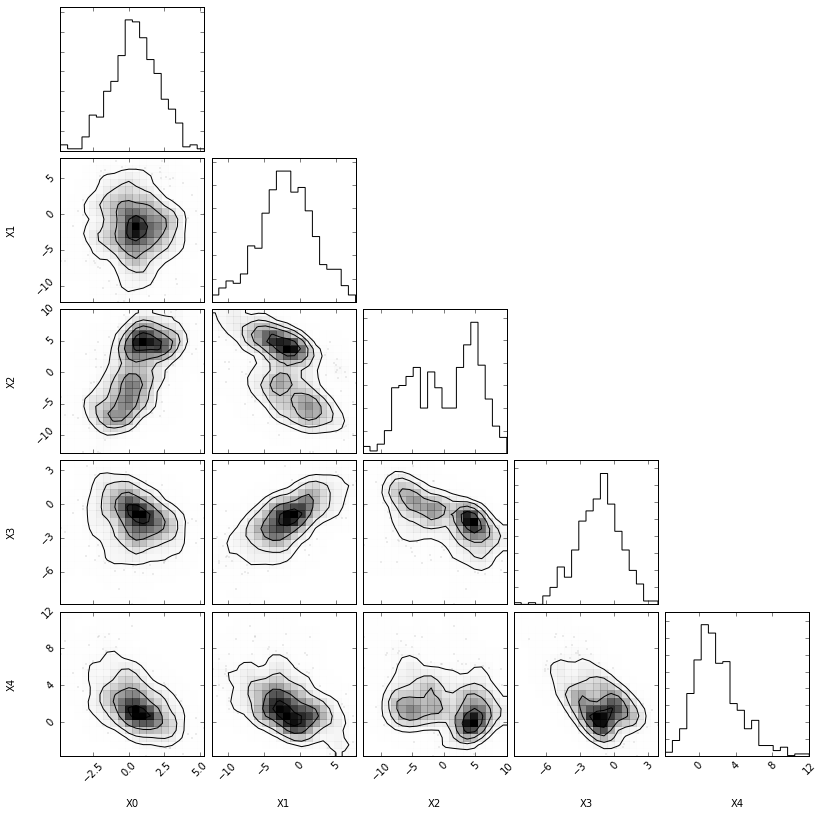

In [56]:
import corner
fig = corner.corner(X_true, bins=20, smooth=1, labels=["X0", "X1", "X2", "X3", "X4"])

# Known likelihood setup

In [57]:
from scipy.optimize import minimize

def nll_true(theta, X):
    A.set_value(theta[0])
    B.set_value(theta[1])
    return (p0.nnlf(X) - p1.nnlf(X)).sum()

r = minimize(nll_true, x0=[0, 0], args=(X_true,))
true_MLE = r.x

print("True MLE =", true_MLE)

True MLE = [ 0.89637495 -0.98457823]


In [68]:
# True contours
A.set_value(true_A)
B.set_value(true_B)

bounds = [(true_MLE[0] - 0.16, true_MLE[0] + 0.16),
          (true_MLE[1] - 0.5, true_MLE[1] + 0.5)]

As = np.linspace(*bounds[0], 100)
Bs = np.linspace(*bounds[1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

true_contours = np.zeros(len(X))

i = 0
for a in As:
    for b in Bs:
        true_contours[i] = nll_true([a, b], X_true)
        i += 1
        
true_contours = 2. * (true_contours - r.fun)

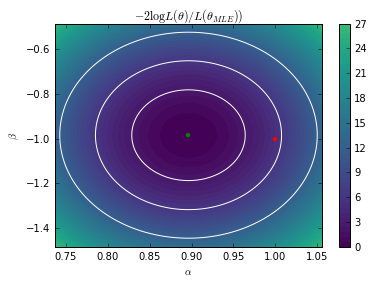

In [69]:
from scipy.stats import chi2
plt.contour(As, Bs, true_contours.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, true_contours.reshape(AA.shape).T, 50, vmin=0, vmax=40)
cb = plt.colorbar()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.axis((*bounds[0], *bounds[1]))
plt.title(r"$-2 \log L(\theta) / L(\theta_{MLE}))$")
#plt.savefig("contours-true.pdf")
plt.show()

# Likelihood-free setup

In [70]:
# Build classification data
from carl.learning import make_parameterized_classification

bounds = [(-3, 3), (-3, 3)]

X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(A, np.linspace(*bounds[0], num=30)), 
     (B, np.linspace(*bounds[1], num=30))],
    random_state=1)

In [71]:
# Train parameterized classifier
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=0))),
    [A, B])
clf.fit(X, y)

ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(40,...
       shuffle=True, tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start=False)))]),
            params=[A, B])

In [72]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, n_trials=1):    
    print(theta)
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])
    
    s = 0.
    
    for n in range(n_trials):
        # Fit ratio
        ratio = ClassifierRatio(CalibratedClassifierCV(
            base_estimator=clf, 
            cv="prefit",  # keep the pre-trained classifier
            method="histogram", bins=50))

        X0 = p0.rvs(n_samples=100000)
        X1 = p1.rvs(n_samples=100000, random_state=random_state)
        X = np.vstack((X0, X1))
        y = np.zeros(len(X))
        y[len(X0):] = 1

        ratio.fit(X, y)

        #ratio.fit(numerator=p0, denominator=p1, n_samples=100000)

        # Evaluate log-likelihood ratio
        r = ratio.predict(X_true, log=True)
        value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                             # this will need to be rescaled by len(X_true)    
            
        s += value
            
    return s / n_trials

In [73]:
from GPyOpt.methods import BayesianOptimization
bounds = [(-3, 3), (-3, 3)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.08496689  1.10783006]
[-2.1670859  -0.17069098]
[ 1.22075193 -0.49144057]
[ 1.96157191  2.64360015]
[ 0.42633901  1.86093804]
[ 1.99871076 -0.57142586]
[ 0.86514979 -3.        ]
[ 0.86512346 -1.60306218]
[-0.2452625 -3.       ]
[ 0.91326384 -1.01787332]
[ 0.91403818 -1.27181741]
[ 0.91010939 -0.96296716]
[ 1.0850732  -1.36562403]
[-2.86520195  2.84098165]
[ 0.89001497 -0.71791495]
[ 0.95799857 -0.71355441]
[ 0.92800475 -1.17326035]
[ 1.0130966  -1.04843285]
[ 0.81609791 -0.95310839]
[ 0.99424046 -1.08281213]
[ 0.03349397  2.9811955 ]
[ 2.96538614  1.56367447]
[ 1.00813468 -1.36085419]
[ 1.9807306  -2.80311898]
[-2.97727348 -2.09888719]
[ 0.9452491  -0.58811063]
[ 0.7794633  -1.05395675]
[ 0.8762859  -0.76652125]
[ 0.90000178 -1.27225626]
[ 1.11843264  0.66169118]
[ 0.81836819 -1.1139277 ]
[ 2.82918285 -2.93970522]
[ 0.88587831 -0.79455459]
[ 0.95692754 -1.03476296]
[ 0.80906992 -1.09681251]
[ 0.70088399 -1.2787206 ]
[ 1.2570364  2.9048281]
[ 0.93336144 -1.12086204]
[ 0.90083446 -1.

1

In [74]:
est_MLE = solver.x_opt
print("Estimated MLE =", est_MLE)

Estimated MLE = [ 0.90083446 -1.15723987]


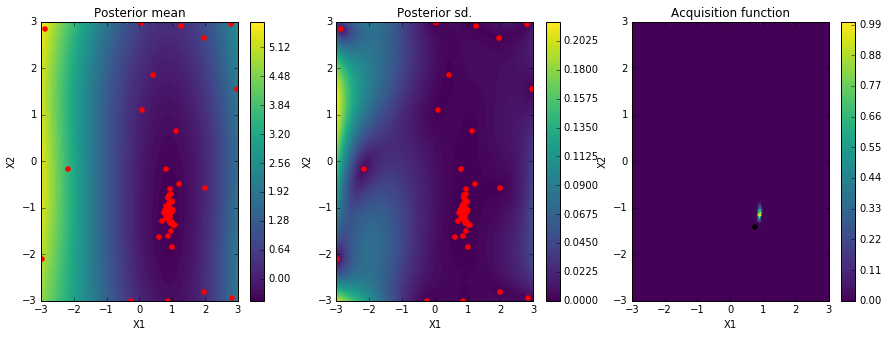

In [75]:
solver.plot_acquisition()

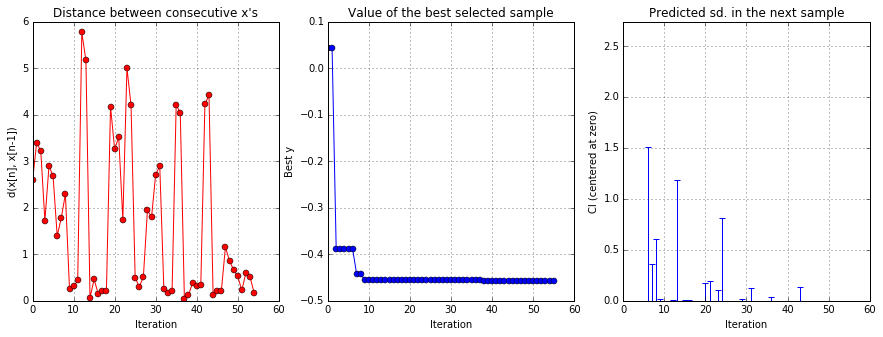

In [76]:
solver.plot_convergence()

In [77]:
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0,0])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

GP MLE = [ 0.89377693 -1.13536941]


In [78]:
A.set_value(true_A)
B.set_value(true_B)

bounds = [(true_MLE[0] - 0.16, true_MLE[0] + 0.16),
          (true_MLE[1] - 0.5, true_MLE[1] + 0.5)]

As = np.linspace(*bounds[0], 100)
Bs = np.linspace(*bounds[1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

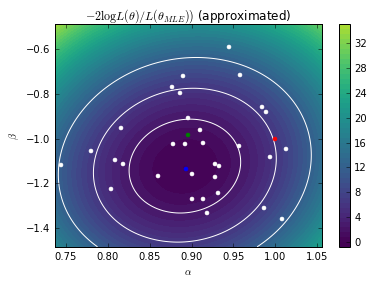

In [80]:
from scipy.stats import chi2
gp_contours, _= solver.model.predict(X)
gp_contours = 2. * (gp_contours - r.fun) * len(X_true)  # Rescale

cs = plt.contour(As, Bs, gp_contours.reshape(AA.shape), 
                 levels=[chi2.ppf(0.683, df=2), 
                         chi2.ppf(0.9545, df=2),
                         chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, gp_contours.reshape(AA.shape), 50, vmin=0, vmax=40)
cb = plt.colorbar()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.plot(solver.X[:,0], solver.X[:,1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.axis((*bounds[0], *bounds[1]))
plt.title(r"$-2 \log L(\theta) / L(\theta_{MLE}))$ (approximated)")
#plt.savefig("contours-gp.pdf")
plt.show()

---

In [81]:
# Scanned contours
A.set_value(true_A)
B.set_value(true_B)

# bounds = [(true_MLE[0] - 1, true_MLE[0] + 1), 
#           (true_MLE[1] - 1, true_MLE[1] + 1)]

bounds = [(true_MLE[0] - 0.16, true_MLE[0] + 0.16),
          (true_MLE[1] - 0.5, true_MLE[1] + 0.5)]

As = np.linspace(*bounds[0], 16)
Bs = np.linspace(*bounds[1], 16)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [ ]:
contours = []

In [95]:
scan_contours = np.zeros(len(X))

i = 0
for a in As:    
    for b in Bs:
        scan_contours[i] = objective([a, b], n_trials=1)  # average over 10 trials
        i += 1
        
contours.append(scan_contours)

[0.73637494793585945, -1.4845782348589567]
[0.73637494793585945, -1.41791156819229]
[0.73637494793585945, -1.3512449015256234]
[0.73637494793585945, -1.2845782348589567]
[0.73637494793585945, -1.2179115681922901]
[0.73637494793585945, -1.1512449015256234]
[0.73637494793585945, -1.0845782348589568]
[0.73637494793585945, -1.0179115681922899]
[0.73637494793585945, -0.95124490152562335]
[0.73637494793585945, -0.8845782348589567]
[0.73637494793585945, -0.81791156819229005]
[0.73637494793585945, -0.7512449015256234]
[0.73637494793585945, -0.68457823485895664]
[0.73637494793585945, -0.61791156819228998]
[0.73637494793585945, -0.55124490152562333]
[0.73637494793585945, -0.48457823485895679]
[0.75770828126919276, -1.4845782348589567]
[0.75770828126919276, -1.41791156819229]
[0.75770828126919276, -1.3512449015256234]
[0.75770828126919276, -1.2845782348589567]
[0.75770828126919276, -1.2179115681922901]
[0.75770828126919276, -1.1512449015256234]
[0.75770828126919276, -1.0845782348589568]
[0.757708

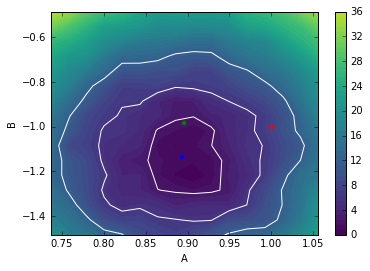

In [96]:
c = sum(contours) / len(contours)
c = 2 * (c - c.min()) * len(X_true)  # or -solver.fx_opt?

plt.contour(As, Bs, c.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, c.reshape(AA.shape).T, 50, vmin=0, vmax=40)
plt.colorbar()
plt.xlabel("A")
plt.ylabel("B")
#plt.plot(solver.X[:,0], solver.X[:,1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.axis((*bounds[0], *bounds[1]))
#plt.savefig("contours-scan.pdf")
plt.show()

In [97]:
def fit_and_plot(theta):
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])

    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X0 = p0.rvs(n_samples=100000)
    X1 = p1.rvs(n_samples=100000, random_state=0)
    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)
    r = ratio.predict(X_true, log=True)
    print(-np.mean(r[np.isfinite(r)]), -np.mean(r[np.isfinite(r)]) * len(X_true), np.isfinite(r).sum())
    
    c = ratio.classifier_.classifiers_[0]
    h = ratio.classifier_.calibrators_[0][0]
    reals = np.linspace(0, 1, num=100)
    plt.plot(reals, h.pdf(reals.reshape(-1, 1)))   
    h = ratio.classifier_.calibrators_[0][1]
    reals = np.linspace(0, 1, num=100)
    plt.plot(reals, h.pdf(reals.reshape(-1, 1)))
    plt.show()
    
    plt.hist(r[np.isfinite(r)], bins=50)
    plt.show()
    

-0.449514249636 -224.757124818 500


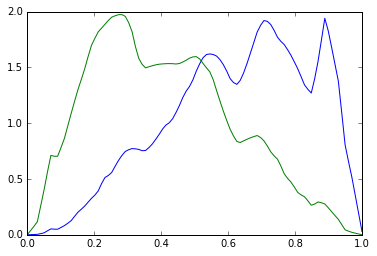

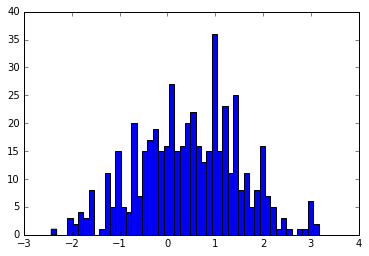

-0.45074118739 -225.370593695 500


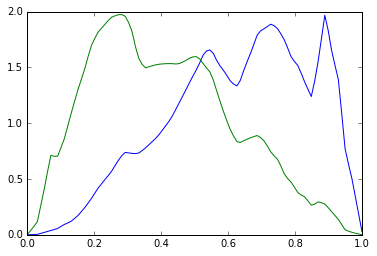

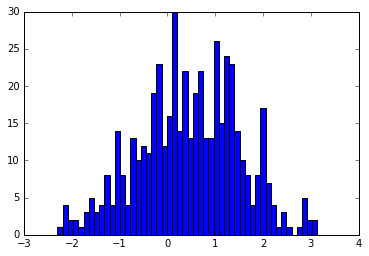

In [98]:
fit_and_plot([true_A, true_B])
fit_and_plot([true_A, true_B])